<a href="https://colab.research.google.com/github/RoshanM-18/Intermediate-Deep-Learning-projects-using-Tensorflow-Keras/blob/main/Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing all the required libraries and downloading the dataset from Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import re
import os
import zipfile
import shutil
import sys
import random
import time
import string
import unicodedata

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
!chmod 600 "/content/kaggle.json"

In [ ]:
!kaggle datasets download -d lonnieqin/englishspanish-translation-dataset

englishspanish-translation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_ref = zipfile.ZipFile("/content/englishspanish-translation-dataset.zip")
zip_ref.extractall()
zip_ref.close()

#### Sneak-peek on the dataset and preparing two different lists for English and Spanish sentences

In [ ]:
data_dir = "/content/data.csv"

In [ ]:
df = pd.read_csv(data_dir)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118964 entries, 0 to 118963
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  118964 non-null  object
 1   spanish  118964 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [ ]:
df.head(10)

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
5,Run!,¡Corre!
6,Run.,Corred.
7,Who?,¿Quién?
8,Fire!,¡Fuego!
9,Fire!,¡Incendio!


In [ ]:
df.tail(10)

,english,spanish
118954,You can't view Flash content on an iPad. Howev...,No puedes ver contenido en Flash en un iPad. S...
118955,A mistake young people often make is to start ...,Un error que cometen a menudo los jóvenes es e...
118956,No matter how much you try to convince people ...,No importa cuánto insistas en convencer a la g...
118957,"In 1969, Roger Miller recorded a song called ""...","En 1969, Roger Miller grabó una canción llamad..."
118958,A child who is a native speaker usually knows ...,Un niño que es hablante nativo normalmente sab...
118959,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118960,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118961,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118962,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
118963,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."


In [ ]:
english_sentences = df.english.tolist()
spanish_sentences = df.spanish.tolist()

#### Text preprocessing

In [ ]:
def clean_text(lines):

  cleaned = []
  table = str.maketrans("", "", string.punctuation)
  for line in lines:
    # normalize unicode characters
    line = unicodedata.normalize("NFD", line).encode("ascii", "ignore")
    line = line.decode("UTF-8")
    # splitting the line into individual words
    line = line.split()
    # lowercase all the words
    line = [word.lower() for word in line]
    # remove punctuations from every sentence
    line = [word.translate(table) for word in line]
    # remove alphanumeric words
    line = [word for word in line if word.isalpha()]
    line = " ".join(line)
    cleaned.append(line)

  return cleaned

In [ ]:
input_size = 5000

random_sentences = random.sample(list(range(0, len(df))), input_size)
english_input = [english_sentences[x] for x in random_sentences]
spanish_input = [spanish_sentences[x] for x in random_sentences]

In [ ]:
english_input = clean_text(english_input)
spanish_input = clean_text(spanish_input)

In [ ]:
english_input[0], spanish_input[0]

('i think ill turn in now', 'creo que me voy a ir a la cama ahora mismo')

In [ ]:
modified_spanish_input = []

for sentence in spanish_input:
  sent = "<START> " + sentence + " <END>"
  modified_spanish_input.append(sent)

In [ ]:
len(english_input), len(modified_spanish_input)

(5000, 5000)

In [ ]:
english_input[0], modified_spanish_input[0]

('i think ill turn in now',
 '<START> creo que me voy a ir a la cama ahora mismo <END>')

In [ ]:
english_words = []
spanish_words = []

for sentence in english_input:
  for word in sentence.split():
    if word not in english_words:
      english_words.append(word)

for sentence in modified_spanish_input:
  for word in sentence.split():
    if word not in spanish_words:
      spanish_words.append(word)

In [ ]:
len(english_words), len(spanish_words)

(3507, 4978)

In [ ]:
english_words.append("<PAD>")
spanish_words.append("<PAD>")

In [ ]:
# english_words = sorted(english_words)
# spanish_words = sorted(spanish_words)

In [ ]:
english_words[0], spanish_words[0]

('i', '<START>')

In [ ]:
num_encoder_tokens = len(english_words)+1
num_decoder_tokens = len(spanish_words)+1

In [ ]:
max_encoder_sequence_length = max([len(sentence.split()) for sentence in english_input])
max_decoder_sequence_length = max([len(sentence.split()) for sentence in modified_spanish_input])

In [ ]:
max_encoder_sequence_length, max_decoder_sequence_length

(27, 28)

In [ ]:
english_vocab_dict = {}
spanish_vocab_dict = {}

eng_count = 1
for word in english_words:
  english_vocab_dict[word] = eng_count
  eng_count += 1

spa_count = 1
for word in spanish_words:
  spanish_vocab_dict[word] = spa_count
  spa_count += 1

In [ ]:
len(english_vocab_dict), len(spanish_vocab_dict)

(3508, 4979)

#### Creating encoder-decoder sequence data

In [ ]:
encoder_input_data = np.zeros(
    (len(english_input), max_encoder_sequence_length, num_encoder_tokens), dtype="float32"
)

In [ ]:
decoder_input_data = np.zeros(
    (len(modified_spanish_input), max_decoder_sequence_length, num_decoder_tokens), dtype="float32"
)

In [ ]:
decoder_output_data = np.zeros(
    (len(modified_spanish_input), max_decoder_sequence_length, num_decoder_tokens), dtype="float32"
)

In [ ]:
for i, (input_text, target_text) in enumerate(zip(english_input, modified_spanish_input)):

  for index, word in enumerate(input_text.split()):
    encoder_input_data[i, index, english_vocab_dict[word]] = 1.0
  encoder_input_data[i, index+1:, english_vocab_dict["<PAD>"]] = 1.0

  for index, word in enumerate(target_text.split()):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, index, spanish_vocab_dict[word]] = 1.0
    if index>0:
      # decoder_target_data will be ahead by one timestep and will not include the <START> token
      decoder_output_data[i, index-1, spanish_vocab_dict[word]] = 1.0
  decoder_input_data[i, index+1:, spanish_vocab_dict["<PAD>"]] = 1.0
  decoder_output_data[i, index:, spanish_vocab_dict["<PAD>"]] = 1.0 

In [ ]:
encoder_input_data[0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
decoder_input_data[0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
decoder_output_data[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
np.where(decoder_input_data[0][0]==1.0)

(array([1]),)

In [ ]:
np.where(decoder_input_data[0][1]==1.0)

(array([2]),)

In [ ]:
np.where(decoder_output_data[0][0]==1.0)

(array([2]),)

In [ ]:
encoder_input_data.shape, decoder_input_data.shape

((5000, 32, 3623), (5000, 35, 5097))

In [ ]:
decoder_output_data.shape

(5000, 35, 5097)

#### Build a sequence to sequence model for neural language translation

In [ ]:
encoder_inputs = keras.layers.Input(shape=(None, num_encoder_tokens))
encoder_lstm = keras.layers.LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = keras.layers.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    epochs=100, batch_size=32, validation_split=0.15)

Epoch 1/100
133/133 [==============================] - 15s 57ms/step - loss: 2.3204 - accuracy: 0.7460 - val_loss: 1.7431 - val_accuracy: 0.7469
Epoch 2/100
133/133 [==============================] - 6s 45ms/step - loss: 1.6365 - accuracy: 0.7586 - val_loss: 1.6835 - val_accuracy: 0.7559
Epoch 3/100
133/133 [==============================] - 6s 45ms/step - loss: 1.5267 - accuracy: 0.7711 - val_loss: 1.6150 - val_accuracy: 0.7596
Epoch 4/100
133/133 [==============================] - 6s 45ms/step - loss: 1.4666 - accuracy: 0.7855 - val_loss: 1.5562 - val_accuracy: 0.7821
Epoch 5/100
133/133 [==============================] - 6s 45ms/step - loss: 1.4185 - accuracy: 0.7913 - val_loss: 1.5356 - val_accuracy: 0.7842
Epoch 6/100
133/133 [==============================] - 6s 45ms/step - loss: 1.3782 - accuracy: 0.7944 - val_loss: 1.5155 - val_accuracy: 0.7859
Epoch 7/100
133/133 [==============================] - 6s 45ms/step - loss: 1.3452 - accuracy: 0.7975 - val_loss: 1.4984 - val_accuracy

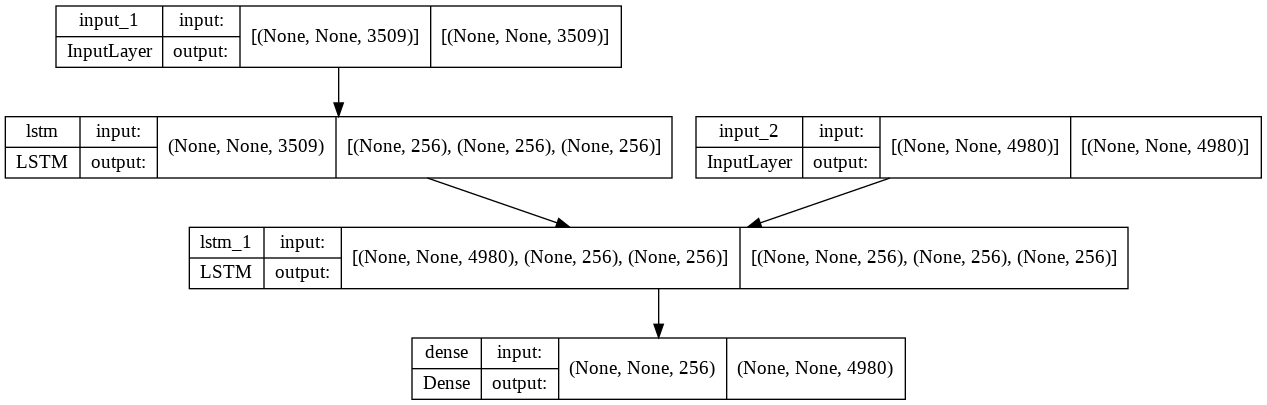

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

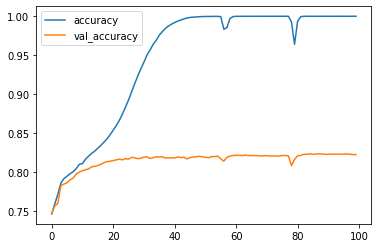

In [ ]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

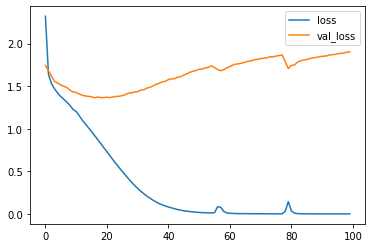

In [ ]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

#### Inference mode 

In [ ]:
inverse_english_vocab = {y:x for x,y in english_vocab_dict.items()}
inverse_spanish_vocab = {y:x for x,y in spanish_vocab_dict.items()}

##### Inference mode TAKE-1

In [ ]:
encoder_inputs = model.input[0] # input_1
encoder_outputs, state_h_encoder, state_c_encoder = model.layers[2].output
encoder_states = [state_h_encoder, state_c_encoder]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1] # input_2
decoder_state_input_h = keras.layers.Input(shape=(256,))
decoder_state_input_c = keras.layers.Input(shape=(256,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_decoder, state_c_decoder = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
decoder_states = [state_h_decoder, state_c_decoder]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(inputs=[decoder_inputs] + decoder_state_inputs,
                            outputs=[decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_sequence):

  # input_sequence = clean_text(input_sequence)
  states_value = encoder_model.predict(input_sequence)

  target_sequence = np.zeros((1,1, num_decoder_tokens))
  target_sequence[0, 0, spanish_vocab_dict["<START>"]] = 1.0

  stop_condition = False
  decoded_sentence = ""
  while not stop_condition:
    output_tokens, hidden_vector, cell_vector = decoder_model.predict([target_sequence]+states_value)

    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = inverse_spanish_vocab[sampled_token_index]
    decoded_sentence += sampled_char

    if sampled_char == "<END>" or len(decoded_sentence)>max_decoder_sequence_length:
      stop_condition = True
    
    target_sequence = np.zeros((1, 1, num_decoder_tokens))
    target_sequence[0, 0, sampled_token_index] = 1.0

    states_value = [hidden_vector, cell_vector]

  return decoded_sentence

In [ ]:
for index in range(20):

  input = encoder_input_data[index:index+1]
  decoded_sentence = decode_sequence(input)
  print(english_sentences[index])
  print(decoded_sentence)
  print("--------------------------------------------------------------")

Go.
creoquemevoyairalacamaahoramismo
--------------------------------------------------------------
Go.
porfavorsirvemeunpocodete<END>
--------------------------------------------------------------
Go.
esteremedioactuarapidamente<END>
--------------------------------------------------------------
Go.
eltrenllegopuntual<END>
--------------------------------------------------------------
Hi.
quientequerriamatar<END>
--------------------------------------------------------------
Run!
nodesvelosusecreto<END>
--------------------------------------------------------------
Run.
nopuedooirle<END>
--------------------------------------------------------------
Who?
elesmasinteligentequeellos<END>
--------------------------------------------------------------
Fire!
yotegustaba<END>
--------------------------------------------------------------
Fire!
yonomeejercitomuchoestosdias<END>
--------------------------------------------------------------
Fire!
hubounaexplosion<END>
------------------------

##### Inference mode Take-2

In [ ]:
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_state_input_h = keras.layers.Input(shape=(256,))
decoder_state_input_c = keras.layers.Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h_decoder, state_c_decoder = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h_decoder, state_c_decoder]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model([decoder_inputs]+decoder_states_inputs,
                            [decoder_outputs]+decoder_states)

In [ ]:
def create_encoder_data(input_seq):

  text = clean_text([input_seq])
  encoder_input_inf = np.zeros((1, max_encoder_sequence_length, num_encoder_tokens))

  for i, word in enumerate(text[0].split()):
    encoder_input_inf[0, i, english_vocab_dict[word]] == 1.0
  encoder_input_inf[0, i+1:, english_vocab_dict["<PAD>"]] = 1.0

  return encoder_input_inf

In [ ]:
def decode_sequence(input_seq):
    
    input_seq = create_encoder_data(input_seq)
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, spanish_vocab_dict["<START>"]] = 1.0

    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = inverse_spanish_vocab[sampled_token_index]
        decoded_sentence.append(sampled_char)

        if sampled_char == "<END>" or len(decoded_sentence) >= max_decoder_sequence_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return " ".join(decoded_sentence[:-1])

In [ ]:
input_sent = "I enjoy running and playing"
decoded_sentence = decode_sequence(input_sent)
print(decoded_sentence)

me encanta la musica
